In [124]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np
import math
from sklearn import datasets

## Prerequisite - Prepare the Data 

- Remove null values 
- Remove data wihout labels
- Remove columns not needed for training

In [125]:
iris_data = load_iris() 
df = pd.DataFrame(data=iris_data.data,  
                  columns=iris_data.feature_names)
df['target'] = iris_data.target

In [126]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [127]:
df.drop(df[df.target == 2].index, inplace=True)

<Axes: xlabel='sepal length (cm)', ylabel='sepal width (cm)'>

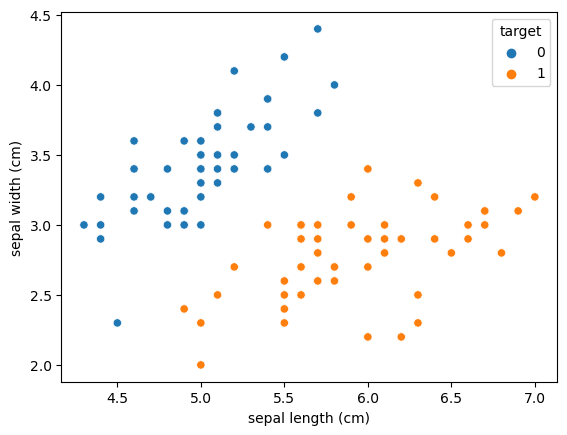

In [128]:
sns.scatterplot(data=df, x="sepal length (cm)", y="sepal width (cm)", hue="target")

In [129]:
# build a simple ANN to predict the target based on "sepal length (cm)" and "sepal width (cm)"
# X contains two features ("sepal length (cm)", "sepal width (cm)"") 
# Y contains the labels (blue:0, orange:1)

In [130]:
x1 = (df[["sepal length (cm)", "sepal width (cm)"]]).to_numpy()
y1 = (df['target']).to_numpy()
m = x1.shape[0]
y1 = y1.reshape([m, 1])

print ('The shape of X is: ' + str(x1.shape))
print ('The shape of Y is: ' + str(y1.shape))
print ('I have m = %d training examples!' % (m))

The shape of X is: (100, 2)
The shape of Y is: (100, 1)
I have m = 100 training examples!


### !!! Note the shape of the data should look like follows !!!
- X[number of features in the input, numbber of samples in the training set]
- Y[number of output nodes, numbber of samples in the training set]

Apply np.transpose if this this not the case. 

In [131]:
X = np.transpose(x1)
Y = np.transpose(y1)

In [132]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of Y is: ' + str(Y.shape))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 100)
The shape of Y is: (1, 100)
I have m = 100 training examples!


# Neural Network model

1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
2. Initialize the model's parameters
3. Loop:
    - Implement forward propagation
    - Compute loss
    - Implement backward propagation to get the gradients
    - Update parameters (gradient descent)

## Step 1: Define the Model Structure

- X -- input dataset of shape (input size, number of examples)
- H -- number of hidden layers 
- Y -- labels of shape (output size, number of examples)
- n_x -- the size of the input layer
- n_h -- the number of neurons in the hidden layer
- n_y -- the size of the output layer
- m -- The number of examples in the training set 

In [133]:
h = 1 # we are initialising the number of hidden layer in the model to 1
n_x = X.shape[0]
m = X.shape[1]
n_h = 4 # we are initialising the number of neurons in the hidden layer to 4 
n_y = Y.shape[0]

print("INPUT PARAMETERS")
print("Size of the input layer - ", n_x)
print("Number of examples in the training set - ", m)

print("HIDDEN LAYER PARAMETERS")
print("Number of hidden layers - ", h)
print("Number of neurons in the hidden layer - ", n_h)

print("OUTPUT LAYER")
print("Size of the output layer - ", n_y)

INPUT PARAMETERS
Size of the input layer -  2
Number of examples in the training set -  100
HIDDEN LAYER PARAMETERS
Number of hidden layers -  1
Number of neurons in the hidden layer -  4
OUTPUT LAYER
Size of the output layer -  1


## Step 2: Initialize Model Parameters

![](images/step2.jpeg)

#### Intialise the following parameters in the model 
- W1 -- weight matrix of shape (n_h, n_x)
- b1 -- bias vector of shape (n_h, 1)
- W2 -- weight matrix of shape (n_y, n_h)
- b2 -- bias vector of shape (n_y, 1

The weights ("W") is initialized to a very small random values, so that W starts out close to the centre of the tanh or sigmoid function, if we start with large value for W, it would slow down the learning. The biases ("b") is initialised to 0

In [134]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y,1))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [135]:
np.random.seed(2)
parameters = initialize_parameters(n_x, n_h, n_y)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))


# Note - matrix structure W[output_node,input_node] and b[output_node,input_node]
# W1  [ 1,1     1,2
#       2,1     2,2
#       3,1     3,2
#       4,1     4,2]
# b1 [ 1,1   1,2   1,3   1,4]

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


## Step 3: Forward Propogation 

Move from the input layer to the output layer.

#### Activation function

$a^{[l]}_{j} = g^{[l]}( \sum \limits _{k}  w^{[l]}_{jk} * a^{[l-1]}_{k} + b^{[l]}_{j})$

Where 

- l - l<sup>th<sup> layer 
- j - j<sup>th<sup> node in layer l
    
```python 
# activation function for node 1 in layer 1 can be computed as follows, 
a1 = tanh(w1[1,1] * x1 + w1[1,2] * x2 + b1[1,1]) 
# activation function for node 2 in layer 1 can be computed as follows,
a2 = tanh(w1[2,1] * x1 + w1[2,2] * x2 + b1[1,2]) 
# activation function for node 3 in layer 1 can be computed as follows,
a3 = tanh(w1[3,1] * x1 + w1[3,2] * x2 + b1[1,3]) 
# activation function for node 4 in layer 1 can be computed as follows,
a4 = tanh(w1[4,1] * x1 + w1[4,2] * x2 + b1[1,4]) 
```


Alternatively the same can be computed using the following matric operation

$$Z^{[1]} =  W^{[1]} X + b^{[1]}$$ 
$$A^{[1]} = \tanh(Z^{[1]})$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$\hat{Y} = A^{[2]} = \sigma(Z^{[2]})$$

In [136]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1 / (1+ np.exp(-z))
    return s

In [137]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [138]:
A2, cache = forward_propagation(X, parameters)

In [139]:
print(A2)

[[0.49990974 0.49995621 0.49991974 0.49992521 0.4998915  0.49988153
  0.49988965 0.4999152  0.49993615 0.49994436 0.49990522 0.49990243
  0.49994982 0.49991792 0.49989526 0.49984151 0.49988153 0.49990974
  0.49991255 0.4998742  0.49994074 0.49988605 0.49986595 0.49993343
  0.49990243 0.49996259 0.4999152  0.49991613 0.49992797 0.49991974
  0.49993797 0.49994074 0.49984505 0.4998524  0.49994436 0.49993889
  0.49993529 0.49988511 0.4999243  0.49992158 0.49990335 0.50001364
  0.49990059 0.49990335 0.4998742  0.49994982 0.4998742  0.49991336
  0.49989883 0.49992705 0.50006651 0.50002825 0.50007195 0.50007736
  0.50008192 0.50003092 0.50001004 0.50002729 0.50007647 0.50001088
  0.50008104 0.50002001 0.50012102 0.5000446  0.50001271 0.5000592
  0.50000087 0.50004913 0.50013374 0.50006006 0.49999634 0.50005642
  0.50010464 0.50005642 0.50006372 0.50006465 0.50010103 0.50007102
  0.50003822 0.50005459 0.50006552 0.50006552 0.50004913 0.50006188
  0.49998811 0.49997906 0.5000592  0.50012829 0.5

### Step 3.1: Compute the Cost function

Cost function measures the performance of a machine learning model for a data set. Cost function quantifies the error between predicted and expected values and presents that error in the form of a single real number.

#### Logistic regression 

It models the relationship between input features and the probability of the event occurring, where the event is typically represented by the binary outcome (0 or 1).Logistic function is also known as sigmoid function. 

$sigma = \frac{1}{1+e^{-z}}$

- e is the base of the natural logarithm, approximately equal to 2.718

![](images/cost.jpeg)

#### Cost function Logistic regression 

When it comes to Linear Regression, the conventional Cost Function employed is the Mean Squared Error.

$ MSE = \frac{1}{2m} \sum\limits_{i = 1}^{m} (ŷ^{2}_{i} - y^{2}_{i})$

- i = index of sample
- ŷ = predicted value
- y = expected value
- m - number of samples in the data set

The same cannot be used for Logistic regression since sigmoid function is a nonlinear transformation, and evaluating this term within the Mean Squared Error formula results in a non-convex cost function that has multiple local minima. 

For logistic regression, the Cost function is defined as:

![](images/cost_2.jpeg)

putting it together we get, 

$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small$

**Instructions**:
- There are many ways to implement the cross-entropy loss. This is one way to implement one part of the equation without for loops:
$- \sum\limits_{i=1}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1 - A2),1 - Y)
cost = - np.sum(logprobs)          
```

Reference - https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148 


In [140]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation 
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost 
    """
    m = Y.shape[1] 
    logprobs = np.multiply(Y,np.log(A2)) + np.multiply(1-Y,np.log(1-A2))
    cost = -1/m * np.sum(logprobs)
    
    cost = float(np.squeeze(cost)) 

    return cost

In [141]:
cost = compute_cost(A2, Y)
print("cost = ",cost)

cost =  0.6930099444143113


## Step 4: Back Propagation

Backpropagation is the essence of neural net training. It is the practice of fine-tuning the weights of a neural net based on the error rate (i.e. loss) obtained in the previous epoch (i.e. iteration.) Proper tuning of the weights ensures lower error rates, making the model reliable by increasing its generalization.

#### Limitation of back propagation 
- Training data can impact the performance of the model, so high-quality data is essential. 
- Noisy data can also affect backpropagation, potentially tainting its results.  
- It can take a while to train backpropagation models and get them up to speed.  
- Backpropagation requires a matrix-based approach, which can lead to other issues.


![](images/step_bp.jpeg)

Deep learning neural networks are trained using the stochastic gradient descent algorithm.

Stochastic gradient descent is an optimization algorithm that estimates the error gradient for the current state of the model using examples from the training dataset, then updates the weights of the model using the back-propagation of errors algorithm, referred to as simply backpropagation.

The lower the cost function, the predicted output is closer to the actual output. So, to minimize this cost function we use Gradient Descent to determine the global minima.

![global_minima.jpeg](images/global_minima.jpeg)

Back propagation is computed using the following formulas,

![back_propagation.jpeg](images/back_propagation.jpeg)



In [142]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    A1 = cache['A1']
    A2 = cache['A2']
    
    dZ2 = A2 - Y
    dW2 = (1./m) * np.dot(dZ2,np.transpose(A1))
    db2 = (1./m) * np.sum(dZ2, axis=1, keepdims= True)
    dZ1 = np.dot(np.transpose(W2), dZ2) * (1 - np.power(A1, 2))
    dW1 = (1./m) * np.dot(dZ1,np.transpose(X))
    db1 = (1./m) * np.sum(dZ1, axis=1, keepdims= True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [143]:
grads = backward_propagation(parameters, cache, X, Y)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00245638 -0.00173974]
 [ 0.00205219 -0.00151646]
 [-0.00124116  0.00090428]
 [-0.0053392   0.00376265]]
db1 = [[-2.58938841e-07]
 [-9.10664254e-06]
 [ 3.68058997e-06]
 [-2.08060949e-06]]
dW2 = [[ 0.0008762   0.00762958  0.00274315 -0.00321645]]
db2 = [[-1.91004228e-05]]


## Step 5: Update Parameters 

The amount that the weights are updated during training is referred to as the step size or the “learning rate.”. It is a configurable hyperparameter used in the training of neural networks that has a small positive value, often in the range between 0.0 and 1.0.


In [122]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
   
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [123]:
print("FORWARD PROPOGATION")
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
cost = compute_cost(A2, Y)
print("cost = ",cost)

new_parameters = update_parameters(parameters, grads)

print("BACK PROPOGATION")
print("W1 = " + str(new_parameters["W1"]))
print("b1 = " + str(new_parameters["b1"]))
print("W2 = " + str(new_parameters["W2"]))
print("b2 = " + str(new_parameters["b2"]))

A2, cache = forward_propagation(X, new_parameters)
cost = compute_cost(A2, Y)
print("cost = ",cost)

FORWARD PROPOGATION
W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]
cost =  0.6930099444143113
BACK PROPOGATION
W1 = [[-0.00711524  0.00152502]
 [-0.02382459  0.01822246]
 [-0.01644496 -0.0095026 ]
 [ 0.01143585 -0.01696806]]
b1 = [[ 3.10726609e-07]
 [ 1.09279710e-05]
 [-4.41670797e-06]
 [ 2.49673138e-06]]
W2 = [[-0.01163097 -0.01824557  0.00222276  0.02678182]]
b2 = [[2.29205074e-05]]
cost =  0.6928296515387732


# Putting it a all together 

Building your first neural network model 

In [148]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=True):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = X.shape[0]
    n_y = Y.shape[0]
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(0, num_iterations):
         
        # Forward propagation. 
        A2, cache = forward_propagation(X, parameters)
        # Cost function. 
        cost = compute_cost(A2, Y)
        # Backpropagation.
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. 
        parameters = update_parameters(parameters, grads)
        
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [149]:
nn_model(X,Y,4)

Cost after iteration 0: 0.693156
Cost after iteration 1000: 0.693145
Cost after iteration 2000: 0.693142
Cost after iteration 3000: 0.693148
Cost after iteration 4000: 0.693147
Cost after iteration 5000: 0.693147
Cost after iteration 6000: 0.693146
Cost after iteration 7000: 0.693145
Cost after iteration 8000: 0.693143
Cost after iteration 9000: 0.693118


{'W1': array([[ 1.17690894, -0.02226817],
        [ 1.62165152, -1.00347165],
        [-1.1327999 ,  0.17950776],
        [ 1.20505408, -0.09474608]]),
 'b1': array([[ 0.1130491 ],
        [ 0.01616223],
        [-0.08719592],
        [ 0.10884186]]),
 'W2': array([[-0.07967349,  0.41647047, -0.06831913, -0.03922782]]),
 'b2': array([[-0.36577288]])}

# Model Prediction 

Predict with your model by building `predict()`.
Use forward propagation to predict results.

**Reminder**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  

In [150]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    return predictions

In [151]:
predictions = predict(parameters, X)
print("Predictions: " + str(predictions))

Predictions: [[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False  True False False False False False False
  False False  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True False  True
   True  True  True  True  True  True  True  True  True  True  True  True
  False False  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]


In [152]:
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 96%
